In [2]:
pip install hmmlearn

     -------------------------------------- 126.0/126.0 kB 3.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from hmmlearn.hmm import GaussianHMM

In [27]:
df = pd.read_csv(r"C:\Users\jkmfi\Documents\Quant_nifty_project\data\clean\nifty_features_5min.csv")

In [28]:
print(df.columns.tolist())

['TradeDate', 'Close_spot', 'Close_fut', 'EMA_5', 'EMA_15', 'ema_signal', 'delta_CE', 'delta_PE', 'gamma', 'vega', 'theta', 'rho', 'IV_avg', 'IV_spread', 'PCR_OI', 'PCR_VOLUME', 'fut_basis_pct', 'spot_return', 'fut_return', 'delta_neutral_ratio', 'gamma_exposure']


In [29]:
df.rename(columns={'TradeDate': 'Date'}, inplace=True)

In [30]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [31]:
# HMM features
hmm_features = [
    'IV_avg',          # Average IV
    'IV_spread',       # IV Spread
    'PCR_OI',          # OI-based PCR
    'PCR_VOLUME',      # Volume-based PCR
    'fut_basis_pct',   # Futures Basis %
    'spot_return',     # Spot returns
    'fut_return',      # Futures returns
    'delta_CE',        # Call Delta
    'delta_PE',        # Put Delta
    'gamma',           # Gamma
    'vega',            # Vega
    'theta',           # Theta
    'rho'              # Rho
]

In [32]:
# Copy features for HMM
df_hmm = df[hmm_features].copy()

# Replace any infinite values with NaN
df_hmm.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with column mean
df_hmm.fillna(df_hmm.mean(), inplace=True)

# Check results
print("Rows after filling NaNs:", df_hmm.shape[0])
print("Columns used for HMM:", df_hmm.columns.tolist())

Rows after filling NaNs: 250
Columns used for HMM: ['IV_avg', 'IV_spread', 'PCR_OI', 'PCR_VOLUME', 'fut_basis_pct', 'spot_return', 'fut_return', 'delta_CE', 'delta_PE', 'gamma', 'vega', 'theta', 'rho']


In [33]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_hmm)

In [34]:
print("Original df rows:", df.shape[0])
print("HMM features df rows:", df_hmm.shape[0])

Original df rows: 250
HMM features df rows: 250


In [35]:
import numpy as np

print("Any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("Any infs in X_scaled?", np.isinf(X_scaled).any())

Any NaNs in X_scaled? False
Any infs in X_scaled? False


In [36]:
# Copy features
df_hmm = df[hmm_features].copy()

# Replace infinite values with NaN
df_hmm.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with column mean
for col in df_hmm.columns:
    if df_hmm[col].isna().all():  # if entire column is NaN, fill with 0
        df_hmm[col].fillna(0, inplace=True)
    else:
        df_hmm[col].fillna(df_hmm[col].mean(), inplace=True)

# Drop any remaining NaNs just in case
df_hmm.dropna(inplace=True)

# Verify
print("Rows after cleaning:", df_hmm.shape[0])
print("Any NaNs remaining?", df_hmm.isna().any().any())

Rows after cleaning: 250
Any NaNs remaining? False


In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_hmm)

# Verify
import numpy as np
print("Any NaNs in X_scaled?", np.isnan(X_scaled).any())
print("Any infs in X_scaled?", np.isinf(X_scaled).any())

Any NaNs in X_scaled? False
Any infs in X_scaled? False


In [38]:
from hmmlearn.hmm import GaussianHMM

n_regimes = 3
hmm_model = GaussianHMM(n_components=n_regimes, covariance_type='full', n_iter=1000, random_state=42)
hmm_model.fit(X_scaled)

df_hmm['Regime'] = hmm_model.predict(X_scaled)

Model is not converging.  Current: 10378.119239359483 is not greater than 11781.919981595087. Delta is -1403.800742235604


In [39]:
# Inspect state means to decide mapping
state_means = df_hmm.groupby('Regime')[hmm_features].mean()
print(state_means)

# Example mapping (adjust based on your inspection)
state_map = {0:'Sideways', 1:'Bullish', 2:'Bearish'}
df_hmm['Regime_Label'] = df_hmm['Regime'].map(state_map)

# Check
print(df_hmm[['Regime','Regime_Label']].head())

           IV_avg  IV_spread    PCR_OI  PCR_VOLUME  fut_basis_pct  \
Regime                                                              
0       10.676667  -2.126667  0.192743    0.217063       0.006019   
1       10.676667  -2.126667  0.192743    0.217063       0.005642   
2       10.676667  -2.126667  0.192743    0.217063       0.006271   

        spot_return  fut_return  delta_CE  delta_PE     gamma       vega  \
Regime                                                                     
0          0.001873   -0.000858  0.898312 -0.101688  0.000003  11.618083   
1         -0.001541   -0.001436  0.892699 -0.107301  0.000003  11.734987   
2          0.000341   -0.000954  0.902338 -0.097662  0.000003  11.427614   

             theta       rho  
Regime                        
0      -237.684441  1.749712  
1      -253.719197  1.749093  
2      -227.305835  1.732358  
   Regime Regime_Label
0       2      Bearish
1       2      Bearish
2       2      Bearish
3       2      Bearish
4  

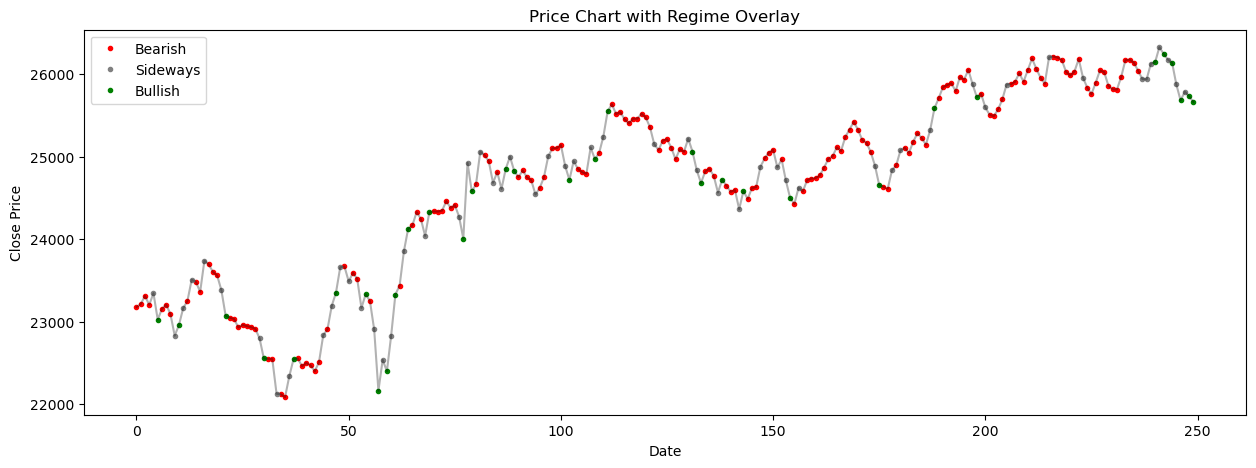

In [40]:
import matplotlib.pyplot as plt

colors = {'Bullish':'green', 'Bearish':'red', 'Sideways':'gray'}

plt.figure(figsize=(15,5))
for regime in df_hmm['Regime_Label'].unique():
    mask = df_hmm['Regime_Label'] == regime
    plt.plot(df_hmm.index[mask], df['Close_spot'].loc[df_hmm.index[mask]], '.', 
             color=colors[regime], label=regime)

plt.plot(df['Close_spot'], color='black', alpha=0.3)  # overall price line
plt.title('Price Chart with Regime Overlay')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

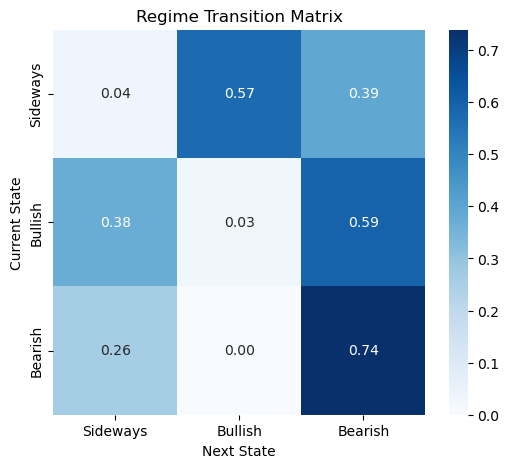

In [41]:
import seaborn as sns
import numpy as np

states = df_hmm['Regime'].values
n_regimes = len(np.unique(states))
transitions = np.zeros((n_regimes, n_regimes))

for (i,j) in zip(states[:-1], states[1:]):
    transitions[i,j] += 1

# Normalize rows to probabilities
transitions = transitions / transitions.sum(axis=1, keepdims=True)

plt.figure(figsize=(6,5))
sns.heatmap(transitions, annot=True, fmt=".2f", cmap='Blues', 
            xticklabels=state_map.values(), yticklabels=state_map.values())
plt.title('Regime Transition Matrix')
plt.xlabel('Next State')
plt.ylabel('Current State')
plt.show()

Regime Statistics:
              IV_avg                                                            \
              count       mean           std        min        25%        50%   
Regime_Label                                                                    
Bearish       161.0  10.676667  1.603709e-14  10.676667  10.676667  10.676667   
Bullish        33.0  10.676667  5.411697e-15  10.676667  10.676667  10.676667   
Sideways       56.0  10.676667  1.792433e-15  10.676667  10.676667  10.676667   

                                   IV_spread            ...       theta  \
                    75%        max     count      mean  ...         75%   
Regime_Label                                            ...               
Bearish       10.676667  10.676667     161.0 -2.126667  ... -233.117207   
Bullish       10.676667  10.676667      33.0 -2.126667  ... -233.117207   
Sideways      10.676667  10.676667      56.0 -2.126667  ... -233.117207   

                            rho           

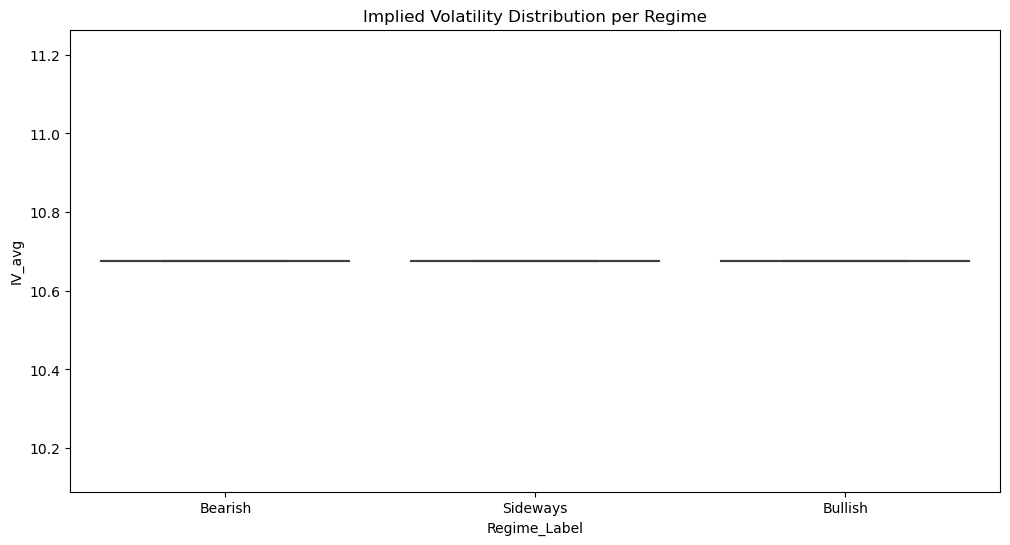

In [42]:
# Compute descriptive stats by regime
stats = df_hmm.groupby('Regime_Label')[hmm_features].describe()
print("Regime Statistics:\n", stats)

# Boxplot for Implied Volatility (correct column name)
plt.figure(figsize=(12,6))
sns.boxplot(x='Regime_Label', y='IV_avg', data=df_hmm)
plt.title('Implied Volatility Distribution per Regime')
plt.show()

In [45]:
df_hmm = df_hmm.copy()

df_hmm['Regime_Change'] = (
    df_hmm['Regime_Label'] != df_hmm['Regime_Label'].shift(1)
).astype(int)

In [46]:
df_hmm['Regime_ID'] = df_hmm['Regime_Change'].cumsum()

In [47]:
durations = (
    df_hmm
    .groupby('Regime_ID')
    .agg(
        Regime_Label=('Regime_Label', 'first'),
        Duration=('spot_return', 'count')
    )
)

print(durations.head())

          Regime_Label  Duration
Regime_ID                       
1              Bearish         4
2             Sideways         1
3              Bullish         1
4              Bearish         3
5             Sideways         1


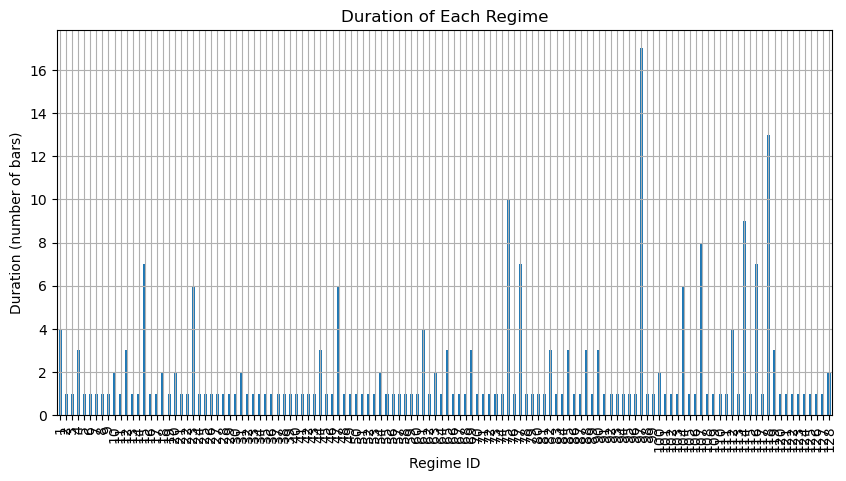

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
durations['Duration'].plot(kind='bar')

plt.title('Duration of Each Regime')
plt.xlabel('Regime ID')
plt.ylabel('Duration (number of bars)')
plt.grid(True)
plt.show()

In [49]:
durations.groupby('Regime_Label')['Duration'].mean()

Regime_Label
Bearish     3.833333
Bullish     1.031250
Sideways    1.037037
Name: Duration, dtype: float64

In [50]:
[x for x in globals().keys() if "hmm" in x.lower()]

['GaussianHMM', 'hmm_features', 'df_hmm', 'hmm_model']

In [52]:
import joblib

In [56]:
joblib.dump(
    hmm_model,
    r"C:\Users\jkmfi\Documents\Quant_nifty_project\models\hmm_model.pkl"
)

['C:\\Users\\jkmfi\\Documents\\Quant_nifty_project\\models\\hmm_model.pkl']